# 1. Data importing

### 1.1 Using Kaggle API

This step works with Google Colab

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
# find your dataset and copy the API command from Kaggle and paste it here like this
!kaggle datasets download -d michaelkitchener/mbti-type-and-digital-footprints-for-reddit-users

In [ ]:
# the json contain API key, which should be sealed and protected by this line of code
!chmod 600 /content/kaggle.json 

In [ ]:
# unzip the downloaded dataset
!unzip /content/mbti-type-and-digital-footprints-for-reddit-users.zip

Archive:  /content/mbti-type-and-digital-footprints-for-reddit-users.zip
  inflating: reddit_psychometric_data.csv  


### 1.2 Access the data

In [ ]:
import pandas as pd

In [ ]:
# read the extracted csv 
mbti_df = pd.read_csv('/content/reddit_psychometric_data.csv')

In [ ]:
print(f"This dataset has {mbti_df.shape[0]:,} entries \
and {mbti_df.shape[1]:,} rows")

This dataset has 3,586 entries and 27,091 rows


In [ ]:
# show the information about this dataframe
mbti_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3586 entries, 0 to 3585
Columns: 27091 entries, mbti_type to comment_PIED
dtypes: int64(27090), object(1)
memory usage: 741.2+ MB


# 2. Data Cleaning

Since it has 27,091 rows, which is 27,090 subreddits in the dataset. I will work with Top 5 subreddits

For example, for the subreddit/memes, you will find:
1. post_memes
2. comment_memes
in the 27,091 rows

I will work with Top 5 subreddits

## 2.1 Choosing top subreddits 

In [ ]:
post_df = mbti_df.filter(regex='^post_|^mbti_type') 
# filter the df with the column that starts with post_ and mbti_type

In [ ]:
# create new dataframe to count with for-loop
datas = [] 
for col in post_df.columns.values.tolist():
    if col == 'mbti_type': # mbti_type does not count
        pass
    else:
        data = [str(col), mbti_df[col].sum()] 
        datas.append(data)

In [ ]:
# take the list of items to df
sorted_post_df = pd.DataFrame(datas, columns=['Name', 'Count'])

In [ ]:
# ascendingly sort value by count and show only 20 entries
sorted_post_df.sort_values('Count', ascending=False).head(20)

,Name,Count
32,post_mbti,5260
29,post_AskReddit,2657
103,post_memes,2220
55,post_infp,2022
119,post_INTP,1882
132,post_teenagers,1368
50,post_mbtimemes,1367
528,post_dankmemes,1290
51,post_ENFP,935
503,post_intj,910


As you can see, there are some MBTI-related subreddits also. I will choose top 5 non-MBTI-related subreddits which are:
1. `'post_AskReddit'`, 
2. `'post_memes'`, 
3. `'post_teenagers'`,
4. `'post_dankmemes'`, 
5. `'post_showerthoughts'`

## 2.2 Create a new and clean dataframe

In [ ]:
non_mbti_post = [
    'post_AskReddit', 'post_memes', 'post_teenagers',
    'post_dankmemes', 'post_Showerthoughts']

In [ ]:
def sort_dup(LIST):
  # remove duplicate mbti from list
  LIST = list(set(LIST)) 
  # sort mbti ascendingly
  LIST.sort()
  return LIST

In [ ]:
# convert all 3,586 entries of mbti to list
mbtis = (mbti_df['mbti_type'].values.tolist()) 
mbtis = sort_dup(mbtis)
print(mbtis)

['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP']


In [ ]:
def count_from_col(MBTI, INDEX):
    return int(mbti_df[mbti_df['mbti_type'].str.contains(MBTI)][[non_mbti_post[INDEX]]].sum(axis=0))

In [ ]:
datas = [] #empty list of final data to append to our new TOP5 dataframe
for mbti in mbtis:
    each_mbti_data=[mbti]
    for i in range(5):
      count = count_from_col(mbti, i)
      each_mbti_data.append(count)
    
    datas.append(each_mbti_data)

In [ ]:
#create new dataframe to work with
my_work = pd.DataFrame(datas, columns=['mbti_type']+non_mbti_post) 
my_work # data is now cleaner than before

,mbti_type,post_AskReddit,post_memes,post_teenagers,post_dankmemes,post_Showerthoughts
0,ENFJ,39,14,64,3,3
1,ENFP,298,98,83,67,47
2,ENTJ,129,88,31,33,21
3,ENTP,325,410,293,233,109
4,ESFJ,2,0,0,0,2
5,ESFP,5,3,1,22,3
6,ESTJ,3,4,7,3,0
7,ESTP,36,10,16,8,7
8,INFJ,311,180,128,77,74
9,INFP,403,251,211,133,117


# 3. Data Visualisation

In [ ]:
import numpy as np

In [ ]:
extroverts_df = my_work[np.char.find(my_work['mbti_type'].values.astype(str), 'E') > -1]
introverts_df = my_work[np.char.find(my_work['mbti_type'].values.astype(str), 'I') > -1]

# extroverts_df is the dataframe that only contain Exxx in the mbti_type column 
# introverts_df is the dataframe that only contain Ixxx in the mbti_type column 

In [ ]:
# create a new mbti label from recycling the existing list of MBTIs
xMBTIs = []
for mbti in mbtis:
  # replace the first letter of each mbti with 'x'
  xmbti = mbti.replace(mbti[0],'x') 
  xMBTIs.append(xmbti)

xMBTIs = sort_dup(xMBTIs)
print(xMBTIs)

['xNFJ', 'xNFP', 'xNTJ', 'xNTP', 'xSFJ', 'xSFP', 'xSTJ', 'xSTP']


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def visualise(COLUMN_NAME, GRID = True, Y_MAX_LIMIT=None, COLOR_SET = ['steelblue','salmon'], SAVE=False): 
  In = introverts_df[COLUMN_NAME]
  Ex = extroverts_df[COLUMN_NAME]
  y = xMBTIs
  plt.figure(figsize=[11,6])
  # assign x and y values to plot, and also set the colour
  plt.bar(y, In, color=COLOR_SET[0],zorder=3) 
  plt.bar(y ,Ex, bottom=In, color=COLOR_SET[1],zorder=3)
  if GRID is True:
    plt.grid(zorder=0) 
    # grid's zorder > bar, otherwise the grid will visibly overlap the bargraph
  if Y_MAX_LIMIT is not None:
    plt.ylim([0, Y_MAX_LIMIT]) # in case you want to stretch the y-axis
  plt.legend(labels=['Introvert', 'Extrovert'])
  plt.xlabel("MBTI Personality Type", labelpad=10)
  plt.ylabel("Frequency of Posting", labelpad=10) 
  #labelpad = distance between xlabel or ylabel and the bar graph
  plt.title(f"Frequency of MBTI who posts in '{COLUMN_NAME.split('_')[1]}'", y=1.03) 
  #resusing the column name but get rid of the 'post_'
  if SAVE is True:
    plt.savefig(f"{COLUMN_NAME}.png")

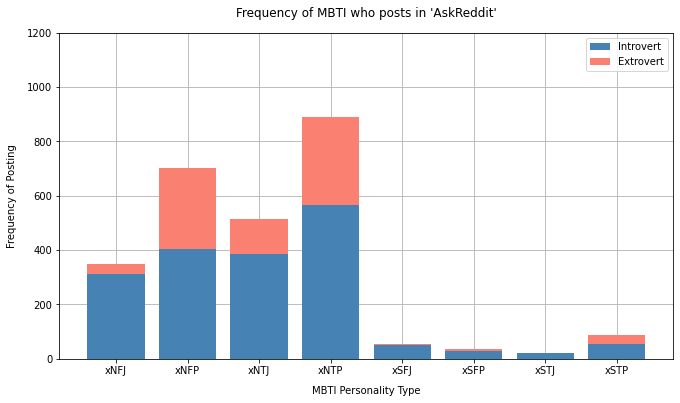

In [ ]:
visualise(non_mbti_post[0],Y_MAX_LIMIT = 1200)

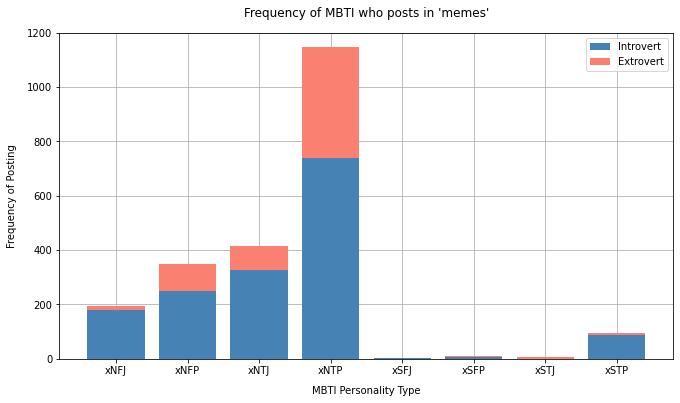

In [ ]:
visualise(non_mbti_post[1],Y_MAX_LIMIT = 1200)

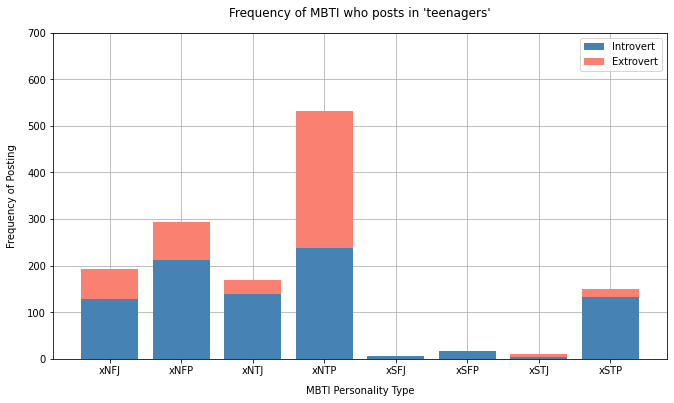

In [ ]:
visualise(non_mbti_post[2],Y_MAX_LIMIT = 700)

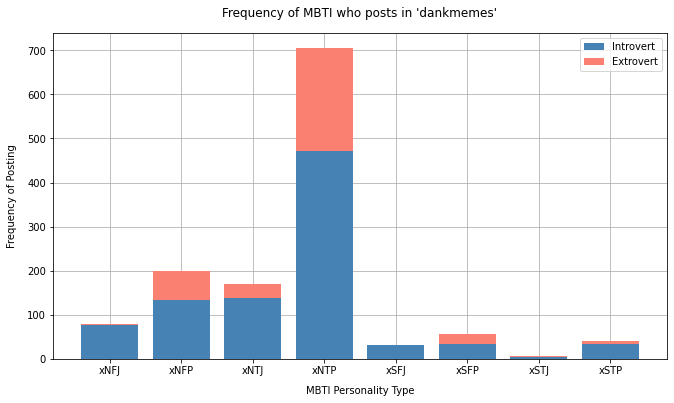

In [ ]:
visualise(non_mbti_post[3])

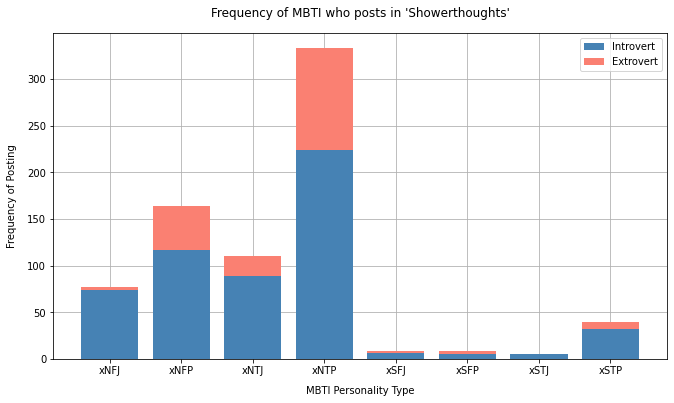

In [ ]:
visualise(non_mbti_post[4])

In [ ]:
# create dataframe of all 
sum_all_post()
plot()

sum_all_comment()
plot()

**References**

5 Python Tips that Absolute Beginners Should Know - Thanawat Piyasawetkul - Medium
https://medium.com/@thanawat.pi/5-python-tricks-that-absolute-beginners-should-know-1aa0244ce320

How to Convert Pandas DataFrame into a List – Data to Fish
https://datatofish.com/convert-pandas-dataframe-to-list/

pandas.DataFrame.groupby — pandas 1.5.2 documentation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html

3 Ways to Select One or More Columns with Pandas - Python and R Tips
https://cmdlinetips.com/2020/04/3-ways-to-select-one-or-more-columns-with-pandas/

Pandas: Select first column of dataframe in python – thisPointer
https://thispointer.com/pandas-select-first-column-of-dataframe-in-python/

Pandas DataFrame sum() Method
https://www.w3schools.com/python/pandas/ref_df_sum.asp#:~:text=The%20sum()%20method%20adds,the%20sum%20of%20each%20row.

Python String replace() Method
https://www.w3schools.com/python/ref_string_replace.asp

In [ ]:
%%shell
jupyter nbconvert --to html /content/mbti_bargraph.ipynb

[NbConvertApp] Converting notebook /content/mbti_bargraph.ipynb to html
[NbConvertApp] Writing 412603 bytes to /content/mbti_bargraph.html
